In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import sys
print(sys.executable)


C:\Users\PC\Desktop\ml_project\venv\Scripts\python.exe


In [7]:
data= pd.read_csv('final_data.csv')
data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI_14', 'RSI_30',
       'RSI_200', 'MOM_10', 'MOM_30', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change',
       'Log_Returns', 'Volatility_10', 'Volatility_30', 'Future_Close',
       'Price_Change', 'Signal'],
      dtype='object')

## Split Data into Training and Testing Sets

In [8]:
# Define the list of features
features = ['RSI_14', 'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30', 
            'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 
            'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change', 'Log_Returns', 
            'Volatility_10', 'Volatility_30']

# Define the features (X)
X = data[features]

# Define the target variable (y)
y = data['Signal']


In [9]:
y = y.replace({2: 1})  # Replace '2' with '1'

In [10]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

##  Feature Scaling


In [11]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform testing data
X_test_scaled = scaler.transform(X_test)

In [12]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

X_train_scaled shape: (8748, 15)
y_train shape: (8748,)


## LightGboost

In [13]:
from lightgbm import LGBMClassifier
from sklearn.base import is_classifier
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Initialize LightGBM model
model = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

print(is_classifier(model)) 

True


In [14]:
# Step 1: Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Perform cross-validation
cv_results = lgb.cv(
    params={
        'objective': 'binary',
        'metric': 'binary_logloss'  # Use binary_logloss 
    },
    train_set=lgb.Dataset(X_train_scaled, label=y_train),
    num_boost_round=100,
    nfold=5,
    stratified=True,
    shuffle=True
)

# Step 4: Get binary log loss
if 'valid binary_logloss-mean' in cv_results:
    binary_logloss_mean = np.mean(cv_results['valid binary_logloss-mean'])
    print("Cross-Validation Binary Logloss:", binary_logloss_mean)
else:
    print("'valid binary_logloss-mean' not found in cv_results.")

# If you want to calculate accuracy manually, train the model separately
final_model = lgb.LGBMClassifier(objective='binary', random_state=42)
final_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Num

C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Hyperparameter

In [15]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Define the model
model = LGBMClassifier(objective='binary', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}

# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Numb

C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662
[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Numb

C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662
[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462
[LightGBM] [Info] Numb

C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662
[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662
[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462
[LightGBM] [Info] Numb

C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662
[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662
[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662
[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276
[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462
[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662
[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767505 -> initscore=1.194276
[LightGBM] [Info] Start training from score 1.194276


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5371, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767395 -> initscore=1.193662
[LightGBM] [Info] Start training from score 1.193662


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5372, number of negative: 1627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767538 -> initscore=1.194462
[LightGBM] [Info] Start training from score 1.194462


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6714, number of negative: 2034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 8748, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767490 -> initscore=1.194191
[LightGBM] [Info] Start training from score 1.194191
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 100}
Best Score: 0.8393916523727845


##  Rebuild the model with Hyperparameters 

In [16]:
# Train the model with the best parameters
LightGBM = LGBMClassifier(learning_rate=0.1, n_estimators=200, num_leaves=100, objective='binary', random_state=42)
LightGBM.fit(X_train_scaled, y_train)

# Make predictions
y_pred = LightGBM.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data with Tuned Parameters: {accuracy}")


[LightGBM] [Info] Number of positive: 6714, number of negative: 2034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 8748, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.767490 -> initscore=1.194191
[LightGBM] [Info] Start training from score 1.194191
Accuracy on Test Data with Tuned Parameters: 0.8578610603290676


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


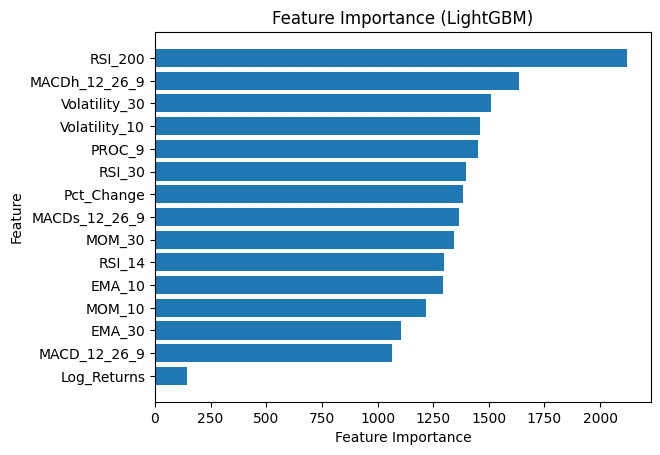

In [17]:
import matplotlib.pyplot as plt

# Plot feature importance
feature_importances = LightGBM.feature_importances_
features = X.columns

# Sort and plot
sorted_idx = feature_importances.argsort()
plt.barh(features[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (LightGBM)")
plt.show()


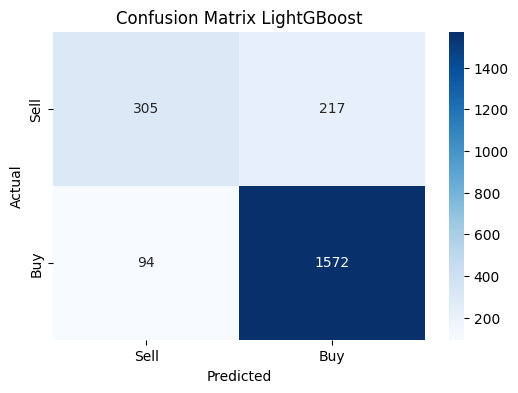

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix LightGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [19]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix as a DataFrame for better readability
cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
print("Confusion Matrix:\n", cm_df)

Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative                 305                 217
Actual Positive                  94                1572


In [20]:
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:\n", classification_report(y_test, y_pred))



Test Accuracy: 85.79%

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.58      0.66       522
           1       0.88      0.94      0.91      1666

    accuracy                           0.86      2188
   macro avg       0.82      0.76      0.79      2188
weighted avg       0.85      0.86      0.85      2188



In [21]:
# Make predictions
y_pred = LightGBM.predict(X_test_scaled)

predictions_df = pd.DataFrame({
    'date': data.iloc[-len(y_test):]['Date'].values,  # Use the actual dates from the original data
    'open': data.iloc[-len(y_test):]['Open'].values,
    'high': data.iloc[-len(y_test):]['High'].values,
    'low': data.iloc[-len(y_test):]['Low'].values,
    'close': data.iloc[-len(y_test):]['Close'].values,
    'volume': data.iloc[-len(y_test):]['Volume'].values,
    'predicted_price': y_pred,
    'decision': ['BUY' if pred == 1 else 'SELL' for pred in y_pred],
    'confidence': LightGBM.predict_proba(X_test_scaled)[:, 1]  # Probability of "BUY"
})

# Save to CSV
predictions_df.to_csv("C:/Users/PC/Desktop/ml_project/Algorithm_Trading_ML/data/final_predictions.csv", index=False)

print("Predictions saved successfully!")


Predictions saved successfully!


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


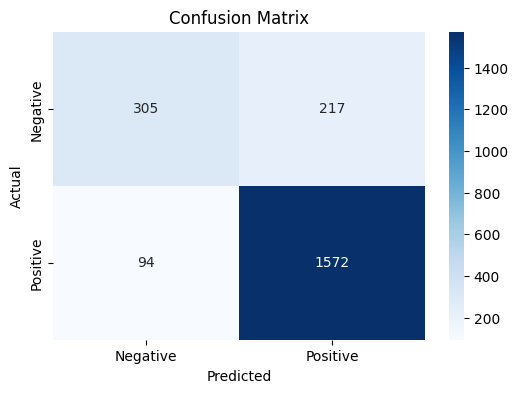

In [22]:
# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# 2. XGBoost Model


In [23]:
import xgboost as xgb
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


In [24]:
# Step 1: Define the list of features and target variable
features = [
    'RSI_14', 'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30',
    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
    'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change', 'Log_Returns',
    'Volatility_10', 'Volatility_30'
]
X = data[features]
y = data['Signal'].replace({2: 1})  # Map '2' to '1' for binary classification


In [25]:
# Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [26]:
# Step 3: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [31]:
# Step 4: Define the Optuna optimization function
def objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
    }
    
    # Perform cross-validation using xgb.cv
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=10,
        seed=42,
        verbose_eval=False
    )
    
    # Return the mean of the test logloss
    return cv_results['test-logloss-mean'].min()


In [32]:
# Step 5: Run Optuna optimization
study = optuna.create_study(direction='minimize', study_name="XGBoost Hyperparameter Tuning")
study.optimize(objective, n_trials=50) 

# Step 6: Display the best hyperparameters
print("Best Hyperparameters:", study.best_params)


[I 2025-02-26 09:59:29,280] A new study created in memory with name: XGBoost Hyperparameter Tuning
[I 2025-02-26 09:59:51,568] Trial 0 finished with value: 0.4332369379000173 and parameters: {'booster': 'dart', 'eta': 0.06901356417966972, 'max_depth': 4, 'min_child_weight': 1.17550229349955, 'subsample': 0.6432754011691653, 'colsample_bytree': 0.6004540638124317, 'lambda': 0.08825772842717264, 'alpha': 0.03376217122601558}. Best is trial 0 with value: 0.4332369379000173.
[I 2025-02-26 09:59:52,561] Trial 1 finished with value: 0.42948438230932207 and parameters: {'booster': 'gbtree', 'eta': 0.20293517039553918, 'max_depth': 7, 'min_child_weight': 5.220048500276468, 'subsample': 0.5885067251722418, 'colsample_bytree': 0.526152790209779, 'lambda': 5.897830401793205, 'alpha': 0.029118556183606672}. Best is trial 1 with value: 0.42948438230932207.
[I 2025-02-26 10:00:11,979] Trial 2 finished with value: 0.40993692685693955 and parameters: {'booster': 'dart', 'eta': 0.1499170614034545, 'max

Best Hyperparameters: {'booster': 'dart', 'eta': 0.061004166911230354, 'max_depth': 10, 'min_child_weight': 1.1255988819586622, 'subsample': 0.8071460412710476, 'colsample_bytree': 0.8854011865461883, 'lambda': 0.0021380208399031323, 'alpha': 0.0462412640230081}


In [33]:
# Step 7: Train the final model with the best hyperparameters
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False  # Avoid deprecation warning
})
XGBoost = xgb.XGBClassifier(**best_params, random_state=42)
XGBoost.fit(X_train_scaled, y_train)


C:\Users\PC\Desktop\ml_project\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [10:17:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.0462412640230081, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8854011865461883, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.061004166911230354, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=0.0021380208399031323, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1.1255988819586622, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [34]:
# Step 8: Evaluate the model on the test set
y_pred = XGBoost.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Test Accuracy: 0.8327239488117002

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.45      0.56       511
           1       0.85      0.95      0.90      1677

    accuracy                           0.83      2188
   macro avg       0.79      0.70      0.73      2188
weighted avg       0.82      0.83      0.82      2188



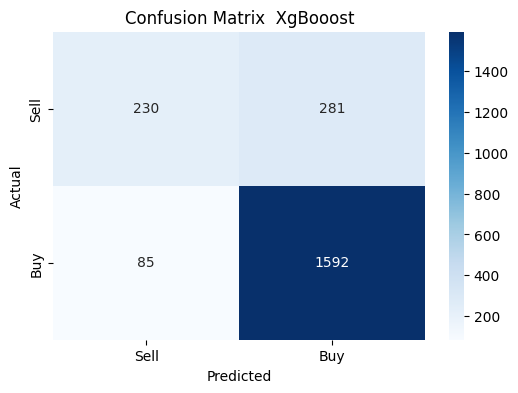

In [35]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix  XgBooost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Random Forest Classifier

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss


def objectiveRD(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestClassifier(**params, random_state=42)
    
    # Evaluation 
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1)
    
    return -np.mean(scores)  # Minimiser la log loss


study = optuna.create_study(direction="minimize")
study.optimize(objectiveRD, n_trials=50)

[I 2025-02-26 10:17:46,856] A new study created in memory with name: no-name-50fb92ab-bb22-4091-a15e-aea0119164e0
[I 2025-02-26 10:18:16,196] Trial 0 finished with value: 0.4051808656745819 and parameters: {'n_estimators': 77, 'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.4051808656745819.
[I 2025-02-26 10:18:23,895] Trial 1 finished with value: 0.4419592176978945 and parameters: {'n_estimators': 177, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 16, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.4051808656745819.
[I 2025-02-26 10:18:30,064] Trial 2 finished with value: 0.4081842539181683 and parameters: {'n_estimators': 102, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.4051808656745819.
[I 2025-02-26 10:18:39,263] Trial 3 finished with value: 0.411041256218009 

In [ ]:
from sklearn.ensemble import RandomForestClassifier  

best_params = study.best_params

best_params.update({
    'random_state': 42
})

# Créer et entraîner le modèle final avec les meilleurs hyperparamètres
rf_model = RandomForestClassifier(**best_params)  
rf_model.fit(X_train_scaled, y_train)


In [ ]:
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix  Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Save Final Model (The best Model)

'''
It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) 
at different thresholds showing how well a model can distinguish between two 
classes such as positive and negative outcomes.

'''


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Your trained models
models = [rf_model, LightGBM, XGBoost]  # Update model names accordingly
model_names = ['Random Forest', 'LightGBM', 'XGBoost']

# Placeholder for actual predicted probabilities
model_probabilities = [
    rf_model.predict_proba(X_test_scaled),  # Random Forest
    LightGBM.predict_proba(X_test_scaled),  # LightGBM
    XGBoost.predict_proba(X_test_scaled)    # XGBoost
]

# Prepare a figure for plotting
plt.figure(figsize=(10, 8))

for i, model in enumerate(models):
    # Get the predicted probabilities for the positive class (class 1)
    y_prob = model_probabilities[i][:, 1]  # Assuming it's a binary classification model
    
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    # Compute the AUC
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')

# Labels and Title
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

# Show the plot
plt.grid(True)
plt.show()


In [ ]:
import joblib

# Save the trained model
joblib.dump(LightGBM, "lightgbm_aapl_model.pkl")

# Load it later for predictions
loaded_model = joblib.load("lightgbm_aapl_model.pkl")
